## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cpu


In [5]:
class Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # Проверим и адаптируем размер
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)  # Автоматическое преобразование тензора
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


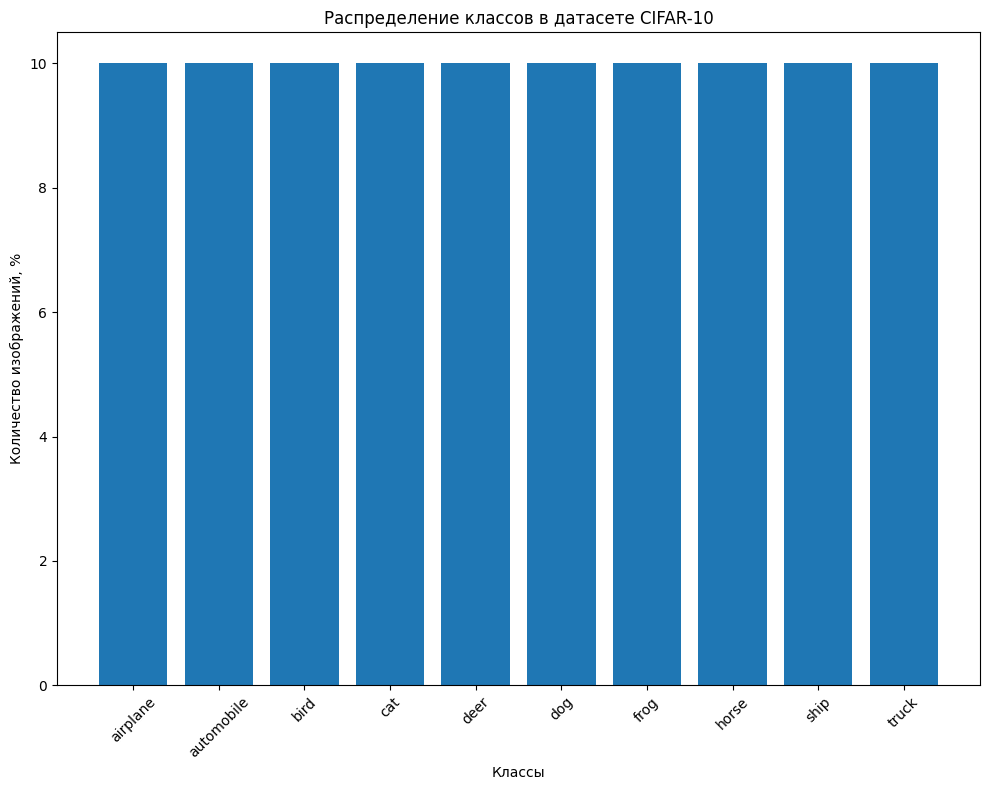

In [6]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Аугментации для обучения
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Аугментация для теста (только нормализация)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка данных
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

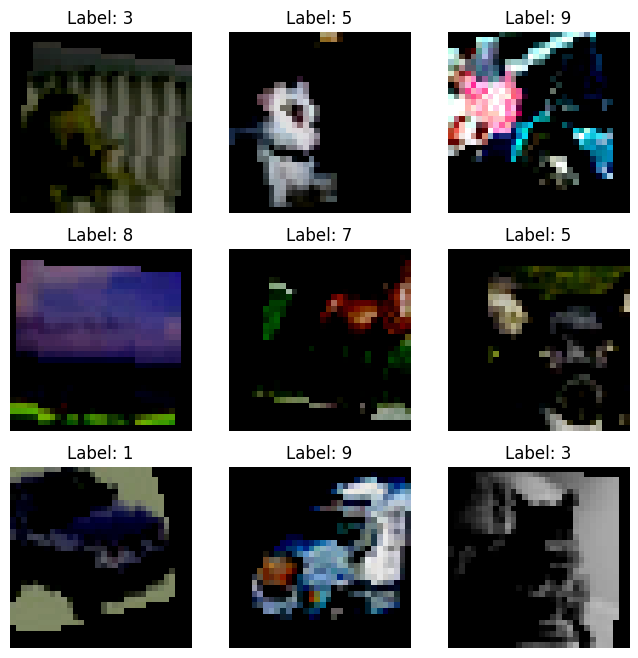

In [7]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Датасет сбалансирован. Поэтому для оценки качества модели подойдут стандартные метрики, такие как Accuracy и Cross-Entropy Loss.

Напишем функции train и test

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.train()
    model = model.to(device) # переносит модель на указанное устройство (GPU или CPU) # .to(?)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc='Train epoch {}/{}'.format(epoch + 1, epochs))
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            # Занулите градиенты оптимизатора
            optimizer.zero_grad() # обнуляет градиенты всех параметров модели перед обратным проходом # .?()
            # Прямой проход
            outputs = model(inputs) # происходит прямой проход данных через модель для получения выходных значений # ?
            loss = criterion(outputs, labels) # Вычисление функции потерь между предсказанными выходами модели и истинными метками # (?, ?)

            # Сделайте обратный проход
            loss.backward() # запускает обратный проход для вычисления градиентов по параметрам модели # .?()
            # Сделайте шаг оптимизации
            optimizer.step()

            running_loss += loss.item()

            # Вычислите точность предсказания
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) # Увеличивает переменную `total` на количество элементов в текущем пакете (размер батча) # ?
            correct += (predicted == labels).sum().item() # Увеличивает переменную `correct` на количество правильно предсказанных меток в текущем пакете # ?
            pbar.set_postfix({'loss': '{:.4f}'.format(running_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Acc: {correct/total:.4f}')

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)
        correct = 0
        total = 0
        test_loss = 0.0
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100, desc='Val {}/{}'.format(epoch + 1, epochs))
        with torch.no_grad():
            for batch_idx, (inputs, labels) in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs) # Снова происходит прямой проход данных через модель для получения выходных значений во время проверки (валидации) # (?)
                loss = criterion(outputs, labels) # вычисление функции потерь между предсказанными выходами модели и истинными метками во время проверки # (?, ?)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0) # Увеличивает переменную `total` на количество элементов в текущем пакете во время проверки # ?
                correct += (predicted == labels).sum().item() # Увеличивает переменную `correct` на количество правильно предсказанных меток в текущем пакете во время проверки # ?
                pbar.set_postfix({'loss': '{:.4f}'.format(test_loss / (batch_idx + 1)), 'accuracy': '{:.4f}'.format(correct / total)})
        val_loss_history.append(test_loss / len(val_loader))
        val_acc_history.append(correct / total)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) # происходит прямой проход данных через модель для получения выходных значений # ?
            loss = criterion(outputs, labels) # вычисление функции потерь между предсказанными выходами модели и истинными метками во время проверки # (?, ?)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) # Увеличивает переменную `total` на количество элементов в текущем пакете во время проверки # ?
            correct += (predicted == labels).sum().item() # Увеличивает переменную `correct` на количество правильно предсказанных меток в текущем пакете во время проверки # ?

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

Обучающая выборка используется для тренировки модели, она учится выявлять паттерны и зависимости в данных. Валидационная выборка позволяет оценить качество модели на данных, которые она не видела во время обучения. Это помогает избежать переобучения и настроить гиперпараметры

In [9]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

Оптимизатор я возьму Adam, потому что он лучше справляется с регуляризацией, что помогает избежать переобучения. Функция потерь я возьму CrossEntropyLoss, так как она хорошо подходит для многоклассовой классификации

In [10]:
# Гиперпараметры
learning_rate = 0.0005  # Скорость обучения - параметр оптимизатора, определяющий размер шага при обновлении весов модели
num_epochs = 70 # Количество эпох - количество полных проходов через все обучающие данные
batch_size = 64 # Размер пакета - количество примеров обучающих данных, передаваемых модели за одну итерацию

model = Baseline().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss() # Функция потерь для задачи классификации
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Оптимизатор Adam для обновления параметров модели на основе градиентов

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Model params:  919306


Обучите модель и постройте графики обучения

In [11]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Train epoch 1/70: 100%|█████████████| 704/704 [03:43<00:00,  3.15it/s, loss=1.6525, accuracy=0.3873]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1, Loss: 1.6525, Acc: 0.3873


Train epoch 2/70: 100%|█████████████| 704/704 [03:48<00:00,  3.08it/s, loss=1.3479, accuracy=0.5132]


Epoch 2, Loss: 1.3479, Acc: 0.5132


Train epoch 3/70: 100%|█████████████| 704/704 [03:51<00:00,  3.03it/s, loss=1.2148, accuracy=0.5664]


Epoch 3, Loss: 1.2148, Acc: 0.5664


Train epoch 4/70: 100%|█████████████| 704/704 [03:49<00:00,  3.06it/s, loss=1.1267, accuracy=0.6003]


Epoch 4, Loss: 1.1267, Acc: 0.6003


Train epoch 5/70: 100%|█████████████| 704/704 [03:51<00:00,  3.04it/s, loss=1.0644, accuracy=0.6255]


Epoch 5, Loss: 1.0644, Acc: 0.6255


Train epoch 6/70: 100%|█████████████| 704/704 [03:49<00:00,  3.07it/s, loss=1.0147, accuracy=0.6469]


Epoch 6, Loss: 1.0147, Acc: 0.6469


Train epoch 7/70: 100%|█████████████| 704/704 [03:47<00:00,  3.09it/s, loss=0.9729, accuracy=0.6598]


Epoch 7, Loss: 0.9729, Acc: 0.6598


Train epoch 8/70: 100%|█████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.9296, accuracy=0.6743]


Epoch 8, Loss: 0.9296, Acc: 0.6743


Train epoch 9/70: 100%|█████████████| 704/704 [03:53<00:00,  3.02it/s, loss=0.9150, accuracy=0.6825]


Epoch 9, Loss: 0.9150, Acc: 0.6825


Train epoch 10/70: 100%|████████████| 704/704 [03:54<00:00,  3.00it/s, loss=0.8794, accuracy=0.6947]


Epoch 10, Loss: 0.8794, Acc: 0.6947


Train epoch 11/70: 100%|████████████| 704/704 [03:47<00:00,  3.09it/s, loss=0.8594, accuracy=0.7051]


Epoch 11, Loss: 0.8594, Acc: 0.7051


Train epoch 12/70: 100%|████████████| 704/704 [03:45<00:00,  3.12it/s, loss=0.8344, accuracy=0.7121]


Epoch 12, Loss: 0.8344, Acc: 0.7121


Train epoch 13/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.8200, accuracy=0.7159]


Epoch 13, Loss: 0.8200, Acc: 0.7159


Train epoch 14/70: 100%|████████████| 704/704 [03:49<00:00,  3.06it/s, loss=0.8046, accuracy=0.7225]


Epoch 14, Loss: 0.8046, Acc: 0.7225


Train epoch 15/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.7861, accuracy=0.7288]


Epoch 15, Loss: 0.7861, Acc: 0.7288


Train epoch 16/70: 100%|████████████| 704/704 [03:50<00:00,  3.06it/s, loss=0.7640, accuracy=0.7362]


Epoch 16, Loss: 0.7640, Acc: 0.7362


Train epoch 17/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.7591, accuracy=0.7376]


Epoch 17, Loss: 0.7591, Acc: 0.7376


Train epoch 18/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.7431, accuracy=0.7462]


Epoch 18, Loss: 0.7431, Acc: 0.7462


Train epoch 19/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.7287, accuracy=0.7485]


Epoch 19, Loss: 0.7287, Acc: 0.7485


Train epoch 20/70: 100%|████████████| 704/704 [03:50<00:00,  3.06it/s, loss=0.7116, accuracy=0.7550]


Epoch 20, Loss: 0.7116, Acc: 0.7550


Train epoch 21/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.7040, accuracy=0.7581]


Epoch 21, Loss: 0.7040, Acc: 0.7581


Train epoch 22/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.6967, accuracy=0.7618]


Epoch 22, Loss: 0.6967, Acc: 0.7618


Train epoch 23/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.6904, accuracy=0.7626]


Epoch 23, Loss: 0.6904, Acc: 0.7626


Train epoch 24/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.6793, accuracy=0.7653]


Epoch 24, Loss: 0.6793, Acc: 0.7653


Train epoch 25/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.6737, accuracy=0.7676]


Epoch 25, Loss: 0.6737, Acc: 0.7676


Train epoch 26/70: 100%|████████████| 704/704 [03:47<00:00,  3.09it/s, loss=0.6566, accuracy=0.7735]


Epoch 26, Loss: 0.6566, Acc: 0.7735


Train epoch 27/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.6489, accuracy=0.7780]


Epoch 27, Loss: 0.6489, Acc: 0.7780


Train epoch 28/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.6485, accuracy=0.7763]


Epoch 28, Loss: 0.6485, Acc: 0.7763


Train epoch 29/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.6338, accuracy=0.7814]


Epoch 29, Loss: 0.6338, Acc: 0.7814


Train epoch 30/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.6313, accuracy=0.7823]


Epoch 30, Loss: 0.6313, Acc: 0.7823


Train epoch 31/70: 100%|████████████| 704/704 [03:49<00:00,  3.06it/s, loss=0.6201, accuracy=0.7888]


Epoch 31, Loss: 0.6201, Acc: 0.7888


Train epoch 32/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.6202, accuracy=0.7866]


Epoch 32, Loss: 0.6202, Acc: 0.7866


Train epoch 33/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.6115, accuracy=0.7916]


Epoch 33, Loss: 0.6115, Acc: 0.7916


Train epoch 34/70: 100%|████████████| 704/704 [03:50<00:00,  3.06it/s, loss=0.6100, accuracy=0.7893]


Epoch 34, Loss: 0.6100, Acc: 0.7893


Train epoch 35/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.5985, accuracy=0.7937]


Epoch 35, Loss: 0.5985, Acc: 0.7937


Train epoch 36/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.5952, accuracy=0.7968]


Epoch 36, Loss: 0.5952, Acc: 0.7968


Train epoch 37/70: 100%|████████████| 704/704 [03:51<00:00,  3.04it/s, loss=0.5852, accuracy=0.7995]


Epoch 37, Loss: 0.5852, Acc: 0.7995


Train epoch 38/70: 100%|████████████| 704/704 [03:51<00:00,  3.04it/s, loss=0.5823, accuracy=0.8002]


Epoch 38, Loss: 0.5823, Acc: 0.8002


Train epoch 39/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.5790, accuracy=0.8000]


Epoch 39, Loss: 0.5790, Acc: 0.8000


Train epoch 40/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.5723, accuracy=0.8058]


Epoch 40, Loss: 0.5723, Acc: 0.8058


Train epoch 41/70: 100%|████████████| 704/704 [03:48<00:00,  3.07it/s, loss=0.5665, accuracy=0.8057]


Epoch 41, Loss: 0.5665, Acc: 0.8057


Train epoch 42/70: 100%|████████████| 704/704 [03:49<00:00,  3.07it/s, loss=0.5632, accuracy=0.8079]


Epoch 42, Loss: 0.5632, Acc: 0.8079


Train epoch 43/70: 100%|████████████| 704/704 [03:51<00:00,  3.04it/s, loss=0.5534, accuracy=0.8102]


Epoch 43, Loss: 0.5534, Acc: 0.8102


Train epoch 44/70: 100%|████████████| 704/704 [03:51<00:00,  3.04it/s, loss=0.5535, accuracy=0.8103]


Epoch 44, Loss: 0.5535, Acc: 0.8103


Train epoch 45/70: 100%|████████████| 704/704 [03:54<00:00,  3.00it/s, loss=0.5482, accuracy=0.8117]


Epoch 45, Loss: 0.5482, Acc: 0.8117


Train epoch 46/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.5408, accuracy=0.8124]


Epoch 46, Loss: 0.5408, Acc: 0.8124


Train epoch 47/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.5427, accuracy=0.8144]


Epoch 47, Loss: 0.5427, Acc: 0.8144


Train epoch 48/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.5325, accuracy=0.8150]


Epoch 48, Loss: 0.5325, Acc: 0.8150


Train epoch 49/70: 100%|████████████| 704/704 [03:46<00:00,  3.11it/s, loss=0.5247, accuracy=0.8197]


Epoch 49, Loss: 0.5247, Acc: 0.8197


Train epoch 50/70: 100%|████████████| 704/704 [03:47<00:00,  3.10it/s, loss=0.5292, accuracy=0.8198]


Epoch 50, Loss: 0.5292, Acc: 0.8198


Train epoch 51/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.5222, accuracy=0.8212]


Epoch 51, Loss: 0.5222, Acc: 0.8212


Train epoch 52/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.5232, accuracy=0.8190]


Epoch 52, Loss: 0.5232, Acc: 0.8190


Train epoch 53/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.5139, accuracy=0.8234]


Epoch 53, Loss: 0.5139, Acc: 0.8234


Train epoch 54/70: 100%|████████████| 704/704 [03:47<00:00,  3.09it/s, loss=0.5130, accuracy=0.8224]


Epoch 54, Loss: 0.5130, Acc: 0.8224


Train epoch 55/70: 100%|████████████| 704/704 [03:47<00:00,  3.10it/s, loss=0.5074, accuracy=0.8247]


Epoch 55, Loss: 0.5074, Acc: 0.8247


Train epoch 56/70: 100%|████████████| 704/704 [03:47<00:00,  3.09it/s, loss=0.5080, accuracy=0.8276]


Epoch 56, Loss: 0.5080, Acc: 0.8276


Train epoch 57/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.5009, accuracy=0.8283]


Epoch 57, Loss: 0.5009, Acc: 0.8283


Train epoch 58/70: 100%|████████████| 704/704 [03:47<00:00,  3.10it/s, loss=0.4961, accuracy=0.8285]


Epoch 58, Loss: 0.4961, Acc: 0.8285


Train epoch 59/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.4951, accuracy=0.8308]


Epoch 59, Loss: 0.4951, Acc: 0.8308


Train epoch 60/70: 100%|████████████| 704/704 [03:46<00:00,  3.11it/s, loss=0.4940, accuracy=0.8303]


Epoch 60, Loss: 0.4940, Acc: 0.8303


Train epoch 61/70: 100%|████████████| 704/704 [03:50<00:00,  3.06it/s, loss=0.4929, accuracy=0.8304]


Epoch 61, Loss: 0.4929, Acc: 0.8304


Train epoch 62/70: 100%|████████████| 704/704 [03:49<00:00,  3.06it/s, loss=0.4865, accuracy=0.8328]


Epoch 62, Loss: 0.4865, Acc: 0.8328


Train epoch 63/70: 100%|████████████| 704/704 [03:50<00:00,  3.05it/s, loss=0.4870, accuracy=0.8316]


Epoch 63, Loss: 0.4870, Acc: 0.8316


Train epoch 64/70: 100%|████████████| 704/704 [03:50<00:00,  3.06it/s, loss=0.4830, accuracy=0.8349]


Epoch 64, Loss: 0.4830, Acc: 0.8349


Train epoch 65/70: 100%|████████████| 704/704 [03:47<00:00,  3.09it/s, loss=0.4836, accuracy=0.8321]


Epoch 65, Loss: 0.4836, Acc: 0.8321


Train epoch 66/70: 100%|████████████| 704/704 [03:52<00:00,  3.03it/s, loss=0.4763, accuracy=0.8372]


Epoch 66, Loss: 0.4763, Acc: 0.8372


Train epoch 67/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.4720, accuracy=0.8370]


Epoch 67, Loss: 0.4720, Acc: 0.8370


Train epoch 68/70: 100%|████████████| 704/704 [03:51<00:00,  3.04it/s, loss=0.4727, accuracy=0.8352]


Epoch 68, Loss: 0.4727, Acc: 0.8352


Train epoch 69/70: 100%|████████████| 704/704 [03:52<00:00,  3.03it/s, loss=0.4697, accuracy=0.8420]


Epoch 69, Loss: 0.4697, Acc: 0.8420


Train epoch 70/70: 100%|████████████| 704/704 [03:48<00:00,  3.08it/s, loss=0.4621, accuracy=0.8383]


Epoch 70, Loss: 0.4621, Acc: 0.8383


Val 70/70: 100%|██████████████████████| 79/79 [00:15<00:00,  4.98it/s, loss=0.5617, accuracy=0.8180]


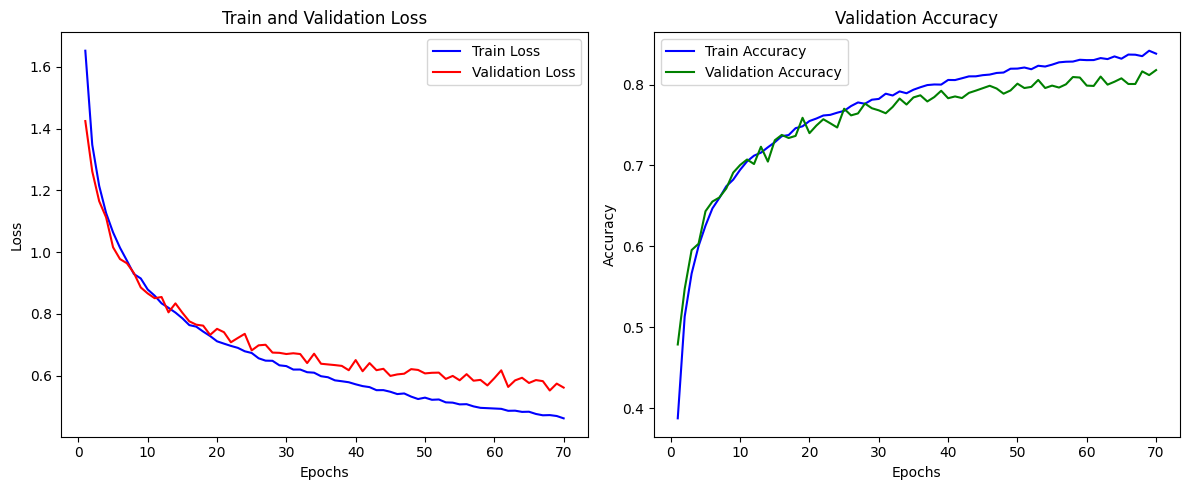

In [12]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Модель показывает хорошую тенденцию к обучению, так как обе кривые (потери и точность) двигаются в правильном направлении. Валидационная точность стабилизируется, что говорит о том, что модель уже достигла своего максимального потенциала на этом наборе данных.

Оцените тестовую метрику на тестовых данных

In [13]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))


Test Loss: 0.4362
Test Accuracy: 0.8553


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов